In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import xml.etree.ElementTree as xet
from glob import glob
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split

In [2]:
!curl -L -o /content/archive.tar.gz "https://www.dropbox.com/scl/fi/khnnv0x8pcpbzlgfevqac/archive.tar.gz?rlkey=55w3pkxp02szjpqw22df7hmn8&dl=0"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   256    0   256    0     0    300      0 --:--:-- --:--:-- --:--:--   300
100   491    0   491    0     0    225      0 --:--:--  0:00:02 --:--:--   515
100  202M  100  202M    0     0  14.5M      0  0:00:13  0:00:13 --:--:-- 19.9M


In [3]:
!tar xfv /content/archive.tar.gz -C /content

archive/
archive/.DS_Store
archive/images/
archive/annotations/
archive/annotations/Cars213.xml
archive/annotations/Cars207.xml
archive/annotations/Cars398.xml
archive/annotations/Cars367.xml
archive/annotations/Cars401.xml
archive/annotations/Cars415.xml
archive/annotations/Cars373.xml
archive/annotations/Cars429.xml
archive/annotations/Cars47.xml
archive/annotations/Cars53.xml
archive/annotations/Cars165.xml
archive/annotations/Cars171.xml
archive/annotations/Cars159.xml
archive/annotations/Cars84.xml
archive/annotations/Cars90.xml
archive/annotations/Cars91.xml
archive/annotations/Cars85.xml
archive/annotations/Cars158.xml
archive/annotations/Cars170.xml
archive/annotations/Cars164.xml
archive/annotations/Cars52.xml
archive/annotations/Cars46.xml
archive/annotations/Cars428.xml
archive/annotations/Cars414.xml
archive/annotations/Cars372.xml
archive/annotations/Cars366.xml
archive/annotations/Cars400.xml
archive/annotations/Cars399.xml
archive/annotations/Cars206.xml
archive/annotati

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3950165551171681230
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1809935161618523409
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [5]:
IMAGE_PATH="/content/archive/images/"
ANNOTATIONS_PATH = "/content/archive/annotations/"

In [6]:

def generate_dataframe_from_xml_annotations(directory):
    path = glob(directory)
    labels_dict = dict(image=[], xmin=[], xmax=[], ymin=[], ymax=[])

    for filename in path:
        info = xet.parse(filename)
        root = info.getroot()
        member_object = root.find('object')
        labels_info = member_object.find('bndbox')
        xmin = int(labels_info.find('xmin').text)
        xmax = int(labels_info.find('xmax').text)
        ymin = int(labels_info.find('ymin').text)
        ymax = int(labels_info.find('ymax').text)

        image_name = os.path.basename(filename)
        image_name = image_name.replace(".xml", ".png")

        labels_dict['image'].append(image_name)
        labels_dict['xmin'].append(xmin)
        labels_dict['xmax'].append(xmax)
        labels_dict['ymin'].append(ymin)
        labels_dict['ymax'].append(ymax)

    df = pd.DataFrame(labels_dict)
    return df

In [7]:
df = generate_dataframe_from_xml_annotations(ANNOTATIONS_PATH+'*.xml')
df

,image,xmin,xmax,ymin,ymax
0,Cars271.png,262,318,141,160
1,Cars227.png,118,153,199,211
2,Cars36.png,203,285,193,229
3,Cars175.png,295,456,237,367
4,Cars354.png,65,102,202,222
...,...,...,...,...,...
428,Cars4.png,156,503,82,253
429,Cars365.png,293,373,205,226
430,Cars206.png,95,164,185,206
431,Cars109.png,115,278,116,153


In [98]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print("Tamanho do DataFrame de treinamento:", len(train_df))
print("Tamanho do DataFrame de teste:", len(test_df))

Tamanho do DataFrame de treinamento: 346
Tamanho do DataFrame de teste: 87


In [127]:
test_df

,image,xmin,xmax,ymin,ymax
425,Cars411.png,160,249,153,197
75,Cars374.png,354,441,118,142
181,Cars375.png,144,300,114,145
30,Cars264.png,222,295,300,337
364,Cars42.png,177,217,140,159
...,...,...,...,...,...
57,Cars160.png,209,281,137,174
124,Cars316.png,377,476,405,439
24,Cars403.png,296,332,189,209
17,Cars143.png,93,130,196,207


In [99]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

def make_dataset(row):
    img = tf.io.read_file(IMAGE_PATH + row)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [64, 64])
    return img

train = list(map(make_dataset, train_df.image.values))
test = list(map(make_dataset, test_df.image.values))

In [114]:
test

[<tf.Tensor: shape=(64, 64, 3), dtype=float32, numpy=
 array([[[ 39.945312,  43.351562,  46.945312],
         [ 26.804688,  26.335938,  27.386719],
         [ 25.65625 ,  30.988281,  27.0625  ],
         ...,
         [119.22266 , 114.05469 , 101.87891 ],
         [110.6875  , 104.875   ,  97.41797 ],
         [ 97.453125,  96.046875,  84.640625]],
 
        [[ 28.714844,  28.796875,  28.390625],
         [ 56.23828 ,  52.45703 ,  49.484375],
         [ 88.44141 ,  84.09766 ,  81.09766 ],
         ...,
         [254.02734 , 255.      , 251.58984 ],
         [254.      , 254.125   , 254.8086  ],
         [253.91797 , 254.      , 252.99219 ]],
 
        [[126.33203 , 122.34375 , 118.73828 ],
         [142.34766 , 133.5039  , 125.53516 ],
         [139.6914  , 136.66016 , 130.6875  ],
         ...,
         [254.9961  , 253.90625 , 250.90234 ],
         [255.      , 255.      , 255.      ],
         [253.98828 , 255.      , 254.01953 ]],
 
        ...,
 
        [[ 50.63672 ,  54.01953 , 

In [100]:
train_ds = tf.data.Dataset.from_tensor_slices((train, (train_df.xmin.values, train_df.ymin.values, train_df.xmax.values, train_df.ymax.values)))
test_ds = tf.data.Dataset.from_tensor_slices((test, (test_df.xmin.values, test_df.ymin.values, test_df.xmax.values, test_df.ymax.values)))

In [101]:
from tensorflow.keras import layers

rescaling = layers.Rescaling(scale=1./127.5, offset=-1)
resizing = layers.Resizing(64, 64)

In [102]:
train_ds = train_ds.map(lambda x, y: (resizing(x), y), num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (resizing(x), y), num_parallel_calls=tf.data.AUTOTUNE)

In [103]:
train_ds = train_ds.batch(128).prefetch(tf.data.AUTOTUNE)

In [106]:
test_ds = test_ds.batch(1).prefetch(tf.data.AUTOTUNE)

In [107]:
test_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None)))>

In [48]:
img_input = layers.Input(shape=(64, 64, 3))

x = img_input
x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
x = layers.AveragePooling2D()(x)
x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.AveragePooling2D()(x)
x = layers.Conv2D(512, (3, 3), padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.AveragePooling2D()(x)
x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.AveragePooling2D()(x)
x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.AveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation="relu")(x)
final = layers.Dropout(0.2)(x)

a = layers.Dense(1, name="a")(final)
b = layers.Dense(1, name="b")(final)
c = layers.Dense(1, name="c")(final)
d = layers.Dense(1, name="d")(final)

model = tf.keras.Model(img_input, [a, b, c, d])

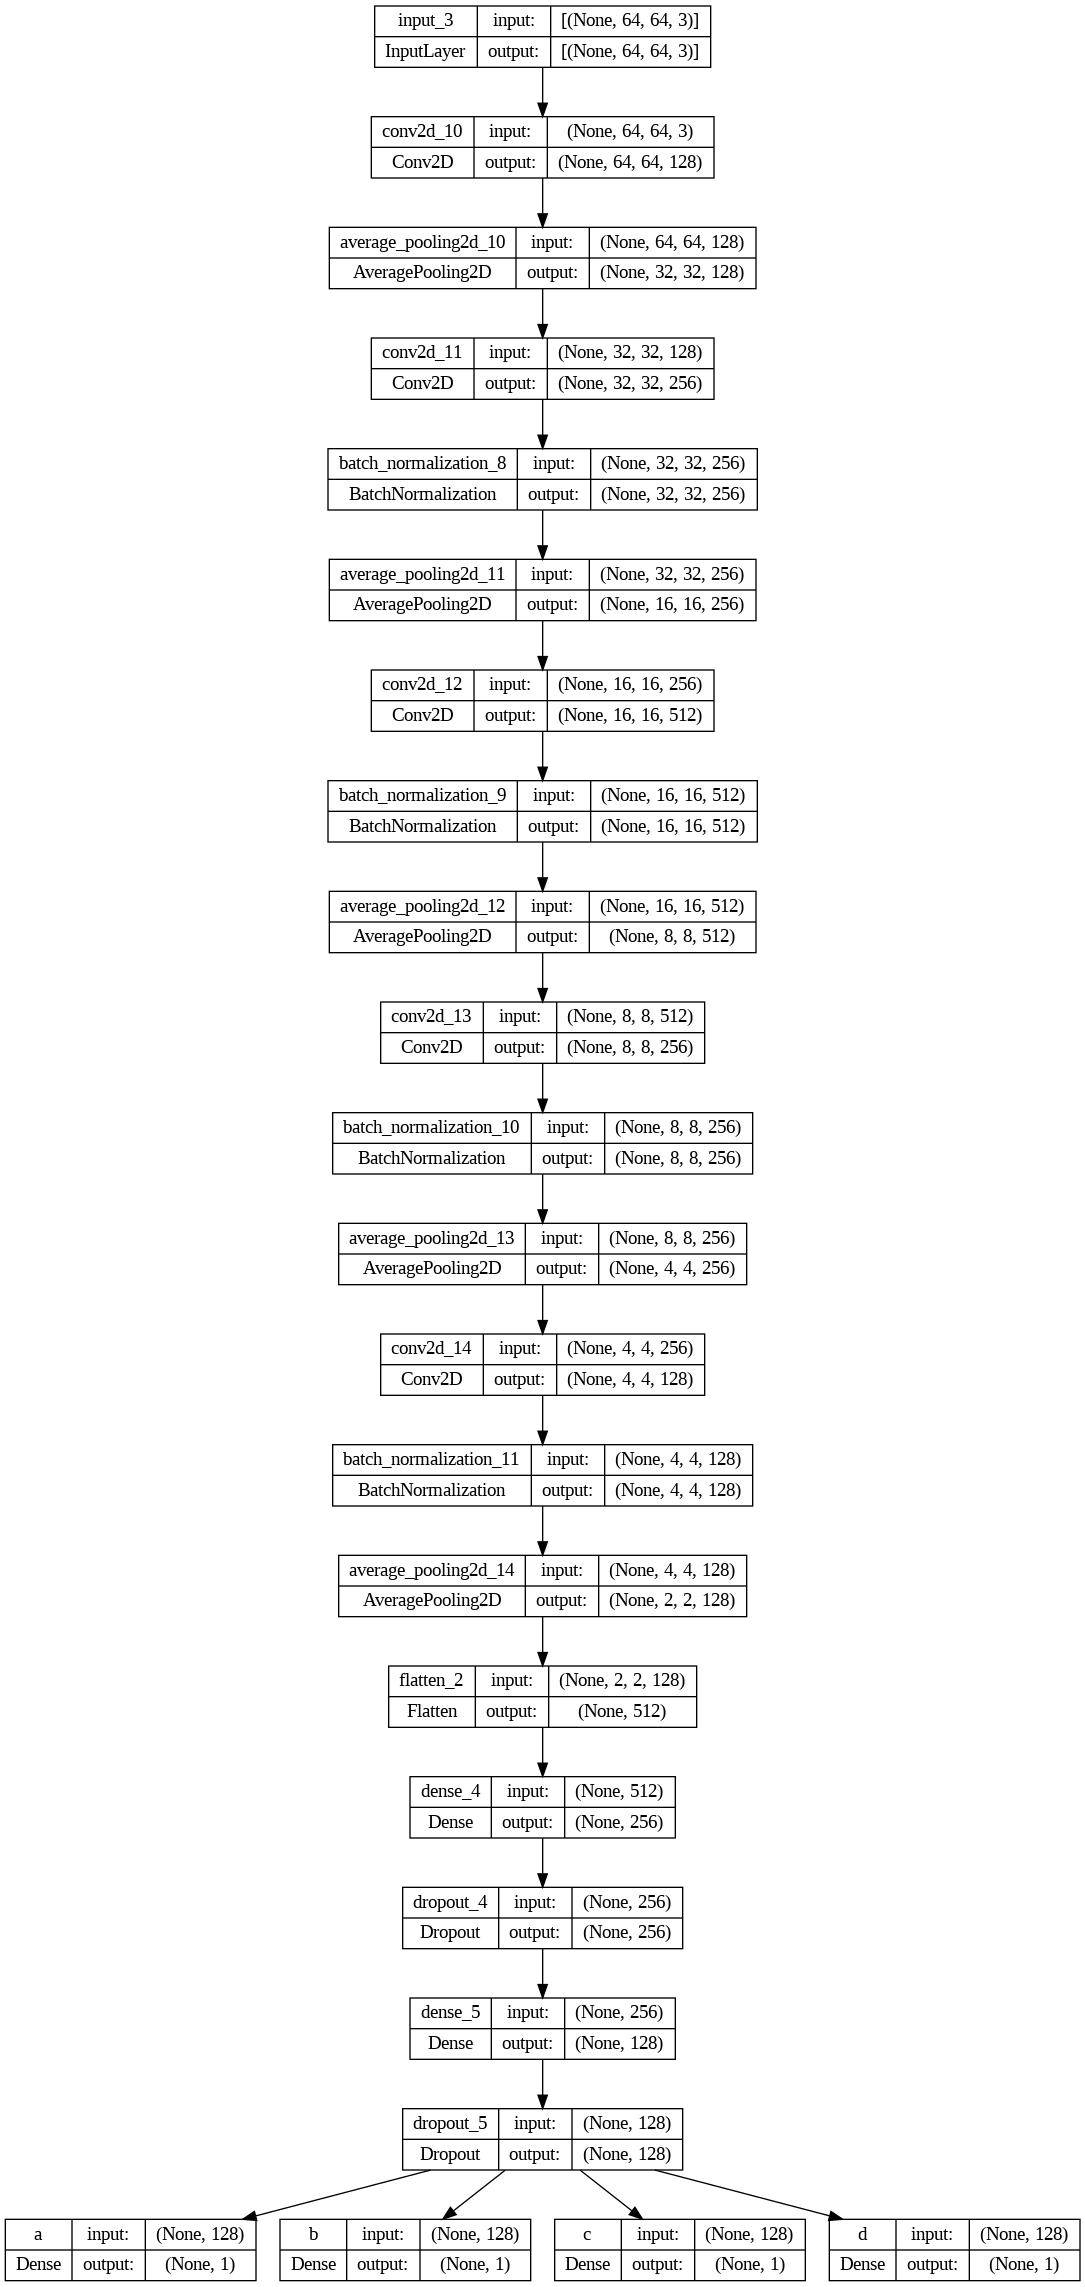

In [49]:
tf.keras.utils.plot_model(model, show_shapes=True)


In [50]:
model.compile(optimizer="adam", loss={
    "a": tf.keras.losses.MeanAbsoluteError(),
    "b": tf.keras.losses.MeanAbsoluteError(),
    "c": tf.keras.losses.MeanAbsoluteError(),
    "d": tf.keras.losses.MeanAbsoluteError()
})

In [51]:
model.fit(train_ds, epochs=500)


Epoch 1/500
4/4 [==============================] - 5s 89ms/step - loss: 792.3000 - a_loss: 165.1362 - b_loss: 161.5883 - c_loss: 267.7440 - d_loss: 197.8315
Epoch 2/500
4/4 [==============================] - 0s 68ms/step - loss: 767.7365 - a_loss: 160.4507 - b_loss: 156.1585 - c_loss: 261.6294 - d_loss: 189.4978
Epoch 3/500
4/4 [==============================] - 0s 69ms/step - loss: 720.3253 - a_loss: 151.4362 - b_loss: 146.3740 - c_loss: 249.7169 - d_loss: 172.7982
Epoch 4/500
4/4 [==============================] - 0s 70ms/step - loss: 640.2882 - a_loss: 135.0920 - b_loss: 131.4333 - c_loss: 228.3409 - d_loss: 145.4220
Epoch 5/500
4/4 [==============================] - 0s 72ms/step - loss: 519.0095 - a_loss: 110.9576 - b_loss: 109.3726 - c_loss: 195.9301 - d_loss: 102.7493
Epoch 6/500
4/4 [==============================] - 0s 69ms/step - loss: 364.4396 - a_loss: 83.4671 - b_loss: 77.7962 - c_loss: 147.1331 - d_loss: 56.0433
Epoch 7/500
4/4 [==============================] - 0s 67ms/st

In [58]:
import cv2

def produce_bounding_box(image):
    test_img = tf.io.read_file(image)
    test_img = tf.image.decode_jpeg(test_img, channels=3)
    test_img = tf.image.resize(test_img, (64, 64))
    test_img = tf.expand_dims(test_img, 0)

    outputs = model(test_img)

    width, height = tf.shape(test_img)[2], tf.shape(test_img)[1]
    xmin = int(outputs[0][0][0].numpy())
    ymin = int(outputs[1][0][0].numpy())
    xmax = int(outputs[2][0][0].numpy())
    ymax = int(outputs[3][0][0].numpy())

    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    bounded = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 4)

    return bounded


136 132 271 162


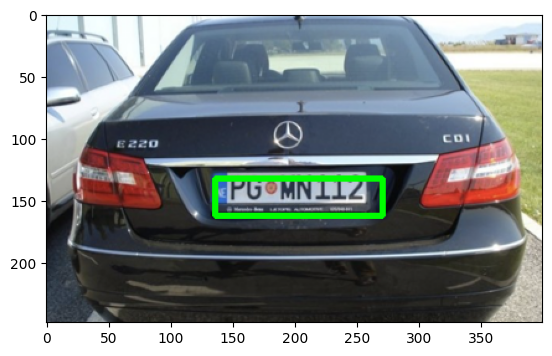

In [61]:
import matplotlib.pyplot as plt
plt.imshow(produce_bounding_box("/content/archive/images/Cars1.png"))

In [116]:
outputs = model.predict(test_ds)


87/87 [==============================] - 0s 4ms/step


In [133]:
predictions = []

for i in range(len(test_df)):
    image_name = test_df.iloc[i]['image']

    image_path = IMAGE_PATH + image_name

    test_img = tf.io.read_file(image_path)
    test_img = tf.image.decode_jpeg(test_img, channels=3)
    test_img = tf.image.resize(test_img, (64, 64))
    test_img = tf.expand_dims(test_img, 0)

    outputs = model(test_img)

    xmin = int(outputs[0][0][0].numpy())
    ymin = int(outputs[1][0][0].numpy())
    xmax = int(outputs[2][0][0].numpy())
    ymax = int(outputs[3][0][0].numpy())

    predictions.append({'image': image_name,
                        'xmin': xmin,
                        'ymin': ymin,
                        'xmax': xmax,
                        'ymax': ymax})

predictions_df = pd.DataFrame(predictions)

In [134]:
predictions_df

,image,xmin,ymin,xmax,ymax
0,Cars411.png,145,155,241,192
1,Cars374.png,418,138,512,169
2,Cars375.png,127,115,301,152
3,Cars264.png,211,299,302,332
4,Cars42.png,187,141,235,157
...,...,...,...,...,...
82,Cars160.png,211,140,288,169
83,Cars316.png,391,414,509,468
84,Cars403.png,306,178,353,194
85,Cars143.png,82,195,121,211


In [141]:
true_positive = false_positive = total_ground_truth = 0
iou_threshold = 0.5

for _, pred_row in predictions_df.iterrows():
    test_row = test_df[test_df['image'] == pred_row['image']]

    for _, test_row in test_row.iterrows():
        intersection_xmin = max(pred_row['xmin'], test_row['xmin'])
        intersection_ymin = max(pred_row['ymin'], test_row['ymin'])
        intersection_xmax = min(pred_row['xmax'], test_row['xmax'])
        intersection_ymax = min(pred_row['ymax'], test_row['ymax'])

        intersection_area = max(0, intersection_xmax - intersection_xmin) * max(0, intersection_ymax - intersection_ymin)
        pred_area = (pred_row['xmax'] - pred_row['xmin']) * (pred_row['ymax'] - pred_row['ymin'])
        test_area = (test_row['xmax'] - test_row['xmin']) * (test_row['ymax'] - test_row['ymin'])
        union_area = pred_area + test_area - intersection_area

        iou = intersection_area / union_area

        if iou >= iou_threshold:
            true_positive += 1
        else:
            false_positive += 1

    total_ground_truth += 1

precision = true_positive / (true_positive + false_positive)
recall = true_positive / total_ground_truth

print("Precisão:", precision)
print("Recall:", recall)

Precisão: 0.5632183908045977
Recall: 0.5632183908045977
